In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split

from tqdm import tqdm

from concrete.ml.torch.compile import compile_torch_model

import matplotlib.pyplot as plt

/home/local/ASURITE/nnjungle/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
#hyperparams
no_epochs = 10
batch_size = 32
learning_rate = 0.001

In [29]:
#transform the dataset into tensors normalized range [-1, 1]
transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5, 0.5, 0.5))     
        ])

In [30]:
#data sets downloading and reading
train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform
                                        )

test_dataset = torchvision.datasets.CIFAR10(root='data',
                                        train=False,
                                        download=True,
                                        transform=transform
                                        )

Files already downloaded and verified
Files already downloaded and verified


In [31]:
# The Dataloaders - used to load data into application for use
train_loader = torch.utils.data.DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True
                            )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                    batch_size=batch_size,
                                    shuffle=False
                                    )

In [32]:
class ConvolutionalNueralNet(nn.Module):
    def __init__(self, n_classes) -> None:
        """Construct the CNN with a configurable number of classes."""
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*4*4, 64)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        x = functional.relu(self.conv1(x))
        x = self.pool(x)
        x = functional.relu(self.conv2(x))
        x = self.pool(x)
        x = functional.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [33]:
model = ConvolutionalNueralNet(10).to(device)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training: 100%|██████████| 10/10 [03:15<00:00, 19.53s/it]


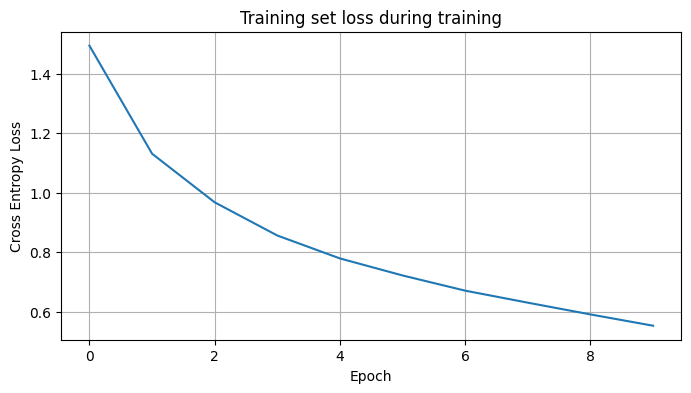

In [36]:
torch.manual_seed(42)

def train_one_epoch(net, optimizer, train_loader):
    # Cross Entropy loss for classification when not using a softmax layer in the network
    loss = nn.CrossEntropyLoss()

    net.train()
    avg_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        loss_net = loss(output, target.long())
        loss_net.backward()
        optimizer.step()
        avg_loss += loss_net.item()

    return avg_loss / len(train_loader)


# Create the tiny CNN with 10 output classes
N_EPOCHS = 10


# Train the network with Adam, output the test set accuracy every epoch
net =model
losses_bits = []
optimizer = torch.optim.Adam(net.parameters())
for _ in tqdm(range(N_EPOCHS), desc="Training"):
    losses_bits.append(train_one_epoch(net, optimizer, train_loader))


fig = plt.figure(figsize=(8, 4))
plt.plot(losses_bits)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.title("Training set loss during training")
plt.grid(True)
plt.show()

In [37]:
#Work now with concrete

def test_with_concrete(quantized_module, test_loader, use_sim):
    """Test a neural network that is quantized and compiled with Concrete ML."""

    # Casting the inputs into int64 is recommended
    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the test batches and accumulate predictions and ground truth labels in a vector
    idx = 0
    for data, target in tqdm(test_loader):
        data = data.numpy()
        target = target.numpy()

        fhe_mode = "simulate" if use_sim else "execute"

        # Quantize the inputs and cast to appropriate data type
        y_pred = quantized_module.forward(data, fhe=fhe_mode)

        endidx = idx + target.shape[0]

        # Accumulate the ground truth labels
        all_targets[idx:endidx] = target

        # Get the predicted class id and accumulate the predictions
        y_pred = np.argmax(y_pred, axis=1)
        all_y_pred[idx:endidx] = y_pred

        # Update the index
        idx += target.shape[0]

    # Compute and report results
    n_correct = np.sum(all_targets == all_y_pred)

    return n_correct / len(test_loader)

In [40]:
#Inputset examples for CIFAR10 dataset

example_input = train_dataset[0]
print(example_input)

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -

In [42]:
n_bits = 6

q_module = compile_torch_model(net, example_input, rounding_threshold_bits=6, p_error=0.1)

start_time = time.time()
accs = test_with_concrete(
    q_module,
    train_loader,
    use_sim=True,
)
sim_time = time.time() - start_time

print(f"Simulated FHE execution for {n_bits} bit network accuracy: {accs:.2f}%")

AttributeError: 'int' object has no attribute 'cpu'

In [110]:
# Generate keys first
t = time.time()
q_module.fhe_circuit.keygen()
print(f"Keygen time: {time.time()-t:.2f}s")

NameError: name 'q_module' is not defined

In [ ]:

t = time.time()
accuracy_test = test_with_concrete(
    q_module,
    test_loader,
    use_sim=False,
)
elapsed_time = time.time() - t
time_per_inference = elapsed_time / len(test_loader)
accuracy_percentage = 100 * accuracy_test

print(
    f"Time per inference in FHE: {time_per_inference:.2f} "
    f"with {accuracy_percentage:.2f}% accuracy"
)